<a href="https://colab.research.google.com/github/Saleh239/Tomato-leaf-disease-detection/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salehmdshahriar","key":"14113c0da5c1c18dcbec1437bf28def3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 99% 177M/179M [00:02<00:00, 79.8MB/s]
100% 179M/179M [00:02<00:00, 72.6MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/tomatoleaf.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.87):
      print("\nReached 87% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/tomato/train'
valid_path = '/content/tomato/val'

In [ ]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

type(vgg)

model = Sequential()
for layer in vgg.layers:
  model.add(layer)

# don't train existing weights
for layer in vgg.layers:
   layer.trainable = False
  

80142336/80134624 [==============================] - 4s 0us/step


In [ ]:
folders = glob('/content/tomato/train/*')
print(len(folders))

10


In [ ]:
import keras
x = Flatten()(vgg.output)
#x = keras.layers.Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
#x = keras.layers.Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   #shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/tomato/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/tomato/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
callbacks = myCallback()
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  callbacks=[callbacks]
  #steps_per_epoch=62,
  #validation_steps=6
)

Epoch 1/30
313/313 [==============================] - 181s 579ms/step - loss: 1.5702 - accuracy: 0.6247 - val_loss: 1.0974 - val_accuracy: 0.7180
Epoch 2/30
313/313 [==============================] - 170s 543ms/step - loss: 0.6491 - accuracy: 0.7772 - val_loss: 0.5335 - val_accuracy: 0.7790
Epoch 3/30
313/313 [==============================] - 170s 543ms/step - loss: 0.5446 - accuracy: 0.8157 - val_loss: 0.4473 - val_accuracy: 0.7480
Epoch 4/30
313/313 [==============================] - 169s 540ms/step - loss: 0.5124 - accuracy: 0.8215 - val_loss: 0.5311 - val_accuracy: 0.8070
Epoch 5/30
313/313 [==============================] - 169s 541ms/step - loss: 0.4437 - accuracy: 0.8439 - val_loss: 0.5586 - val_accuracy: 0.8050
Epoch 6/30
313/313 [==============================] - 169s 539ms/step - loss: 0.4192 - accuracy: 0.8519 - val_loss: 0.4453 - val_accuracy: 0.7850
Epoch 7/30
313/313 [==============================] - 170s 544ms/step - loss: 0.4060 - accuracy: 0.8590 - val_loss: 0.1460 -

In [ ]:
with open ('model_pickle','wb') as f:
  

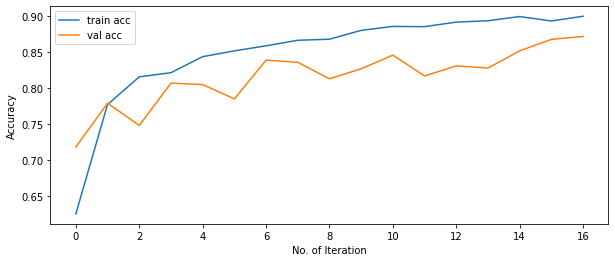

In [ ]:



# accuracies
plt.figure(figsize=(10,4))
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylabel('Accuracy')
plt.xlabel('No. of Iteration')
plt.legend()

#plt.savefig("vgg19graph.eps")
plt.savefig("vgg19graph")
plt.show()



In [ ]:
#Confution Matrix and Classification Report

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
Y_pred = model.predict_generator(test_set ,1000 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['1', '2', '3','4','5','6','7','8','9','10']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[12 10  9  9 14 10 10  8 13  5]
 [ 8  8 12  8 13 10 10  7 15  9]
 [12  8  7  8 13  9 11 12  6 14]
 [ 7  6 15  6  6 14  9 11 11 15]
 [ 8  5 11 12  6  9 14  5 18 12]
 [ 5 11  8 11 11 15  6 13 12  8]
 [ 7  7 10 13 10  9  8 12 12 12]
 [ 8  6 14  9 21 11  5  7  8 11]
 [13  8  7  5 13 10 10 13 11 10]
 [10 10 11  4 15 10  5 14 17  4]]
Classification Report
              precision    recall  f1-score   support

           1       0.13      0.12      0.13       100
           2       0.10      0.08      0.09       100
           3       0.07      0.07      0.07       100
           4       0.07      0.06      0.06       100
           5       0.05      0.06      0.05       100
           6       0.14      0.15      0.14       100
           7       0.09      0.08      0.09       100
           8       0.07      0.07      0.07       100
           9       0.09      0.11      0.10       100
          10       0.04      0.04      0.04       100

    accuracy                      

In [ ]:
import math
number_of_examples = len(test_set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32)) 
# 1.0 above is to skip integer division

test_labels = []
test_images = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_set[i][1]))

for i in range(0,int(number_of_generator_calls)):
    test_images.extend(np.array(test_set[i][0]))


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
print(len(test_labels))

1000


In [ ]:
print(len(test_images))

1000


In [ ]:
predictions = model.predict_generator(test_set)

In [ ]:
print(len(predictions))

1000


In [ ]:
new_labels = []
for i in range(0,1000):
  new_labels.append(np.argmax(predictions[i]))


In [ ]:
print(new_labels[1])

6


In [ ]:
newtest_labels = []
for i in range(0,1000):
  newtest_labels.append(np.argmax(test_labels[i]))


In [ ]:
print(len(newtest_labels))
print(newtest_labels[1])

1000
6


In [ ]:
cm = confusion_matrix(y_true=newtest_labels, y_pred=new_labels)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # plt.savefig("vgg19Matrix.eps")
    plt.savefig("vgg19Matrix")
    

Confusion matrix, without normalization
[[88  1  1  1  4  0  2  3  0  0]
 [ 2 72 10  2  4  5  2  0  3  0]
 [ 0  1 88  3  8  0  0  0  0  0]
 [ 0  3  1 76  9  1  2  2  6  0]
 [ 0  1  4  1 94  0  0  0  0  0]
 [ 0  0  0  0  1 86  5  0  8  0]
 [ 0  1  0  2  1 11 77  0  3  5]
 [ 0  0  0  0  1  0  0 97  2  0]
 [ 0  0  0  0  0  1  0  0 99  0]
 [ 0  0  0  0  0  3  0  0  2 95]]


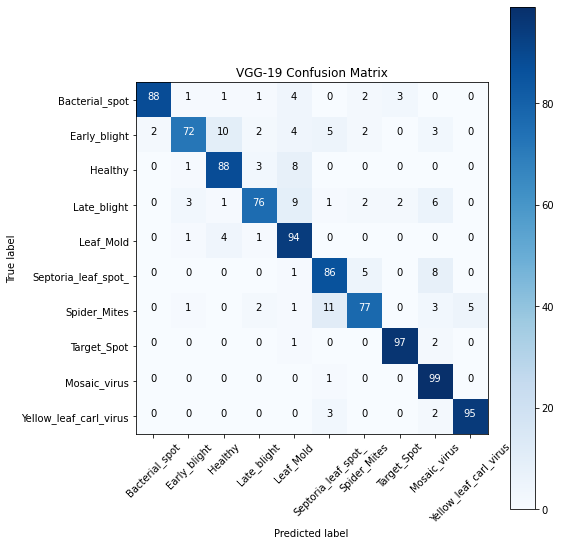

In [ ]:
class_names = ['Bacterial_spot', 'Early_blight', 'Healthy','Late_blight','Leaf_Mold','Septoria_leaf_spot_','Spider_Mites','Target_Spot','Mosaic_virus','Yellow_leaf_carl_virus']
plot_confusion_matrix(cm=cm, classes=class_names, title='VGG-19 Confusion Matrix')

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pickle 
with open ('/content/drive/My Drive/Colab Notebooks/Vgg19.h5','wb') as f:
  pickle.dump (model,f)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Vgg19.h5','rb') as f:
  mp=pickle.load(f)
 

In [ ]:
mp.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   